In [53]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

In [ ]:
roi_df = pd.read_csv("./inputs/roi_data.csv", index_col=0)
roi_df.head()

In [ ]:
roi_df.describe()

In [56]:
ROIs = [
    "Thalamus",
    "Caudate",
    "Putamen",
    "Pallidum",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
]

target_columns = ["thickness_change"] + [region+"_change_pred" for region in ROIs]

In [57]:
#get specific columns of the dataframe
target_df = roi_df.loc[:, target_columns]
PD_MCI_df = target_df.loc[roi_df["dx_group"] == "PD-MCI"]
PD_non_MCI_df = target_df.loc[roi_df["dx_group"] == "PD-non-MCI"]
HC_df = target_df.loc[roi_df["dx_group"] == "HC"]


In [58]:
for region in target_columns:
    t, p = ttest_ind(PD_MCI_df[region], PD_non_MCI_df[region])
    print("PD_MCI vs PD-non-MCI", region, "t:", t, "p:", p)
    t, p = ttest_ind(PD_MCI_df[region], HC_df[region])
    print("PD_MCI vs HC", region, "t:", t, "p:", p)
    t, p = ttest_ind(HC_df[region], PD_non_MCI_df[region])
    print("HC vs PD-non-MCI", region, "t:", t, "p:", p)
    
    

PD_MCI vs PD-non-MCI thickness_change t: 0.7803044843733115 p: 0.44316857788867836
PD_MCI vs HC thickness_change t: 0.002561460210008467 p: 0.9979758052157962
HC vs PD-non-MCI thickness_change t: 0.6764740060093525 p: 0.5037562303559897
PD_MCI vs PD-non-MCI Thalamus_change_pred t: -2.6974337905465893 p: 0.012853576391346953
PD_MCI vs HC Thalamus_change_pred t: -1.1024503037612066 p: 0.28036658495782407
HC vs PD-non-MCI Thalamus_change_pred t: -1.7591149363129652 p: 0.08842614434972539
PD_MCI vs PD-non-MCI Caudate_change_pred t: 0.48466448117971245 p: 0.632498130333897
PD_MCI vs HC Caudate_change_pred t: 0.5884601142519683 p: 0.5613012077526587
HC vs PD-non-MCI Caudate_change_pred t: 0.059704798450297095 p: 0.9527739891773332
PD_MCI vs PD-non-MCI Putamen_change_pred t: -1.2905764995116642 p: 0.20967404871282322
PD_MCI vs HC Putamen_change_pred t: 1.1567190896723225 p: 0.25790484773164063
HC vs PD-non-MCI Putamen_change_pred t: -2.575006465690636 p: 0.015019063040721904
PD_MCI vs PD-non-

- Don't they need multiple comparison correction?
- Numbers are close but not the same. (this was because I used `pred_pct` columns instead of `pred`)

In [59]:
roi_df["dx_group"].value_counts()

HC            18
PD-non-MCI    15
PD-MCI        10
Name: dx_group, dtype: int64

In [60]:
n_regions = len(target_columns)

MCIvsHC_stats = np.zeros((n_regions, 1000, 2))
MCIvsnonMCI_stats = np.zeros((n_regions, 1000, 2))
nonMCIvsHC_stats = np.zeros((n_regions, 1000, 2))

PD_MCI_index = PD_MCI_df.index.tolist()
PD_non_MCI_index = PD_non_MCI_df.index.tolist()
HC_index = HC_df.index.tolist()

n_PD_MCI = len(PD_MCI_index)
n_PD_non_MCI = len(PD_non_MCI_index)
n_HC = len(HC_index)

In [61]:
n_regions

8

In [62]:
for itr in range(1000):

    MCI_sample = list(np.random.choice(PD_MCI_index, n_PD_MCI, replace=True))
    nonMCI_sample = list(np.random.choice(PD_non_MCI_index, n_PD_non_MCI, replace=True))
    HC_sample = list(np.random.choice(HC_index, n_HC, replace=True))

    for i in range(n_regions):
        region = target_columns[i]
        MCIvsnonMCI_stats[i][itr] = ttest_ind(PD_MCI_df[region].loc[MCI_sample], PD_non_MCI_df[region].loc[nonMCI_sample])
        nonMCIvsHC_stats[i][itr] = ttest_ind(HC_df[region].loc[HC_sample], PD_non_MCI_df[region].loc[nonMCI_sample])
        MCIvsHC_stats[i][itr] = ttest_ind(PD_MCI_df[region].loc[MCI_sample], HC_df[region].loc[HC_sample])


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

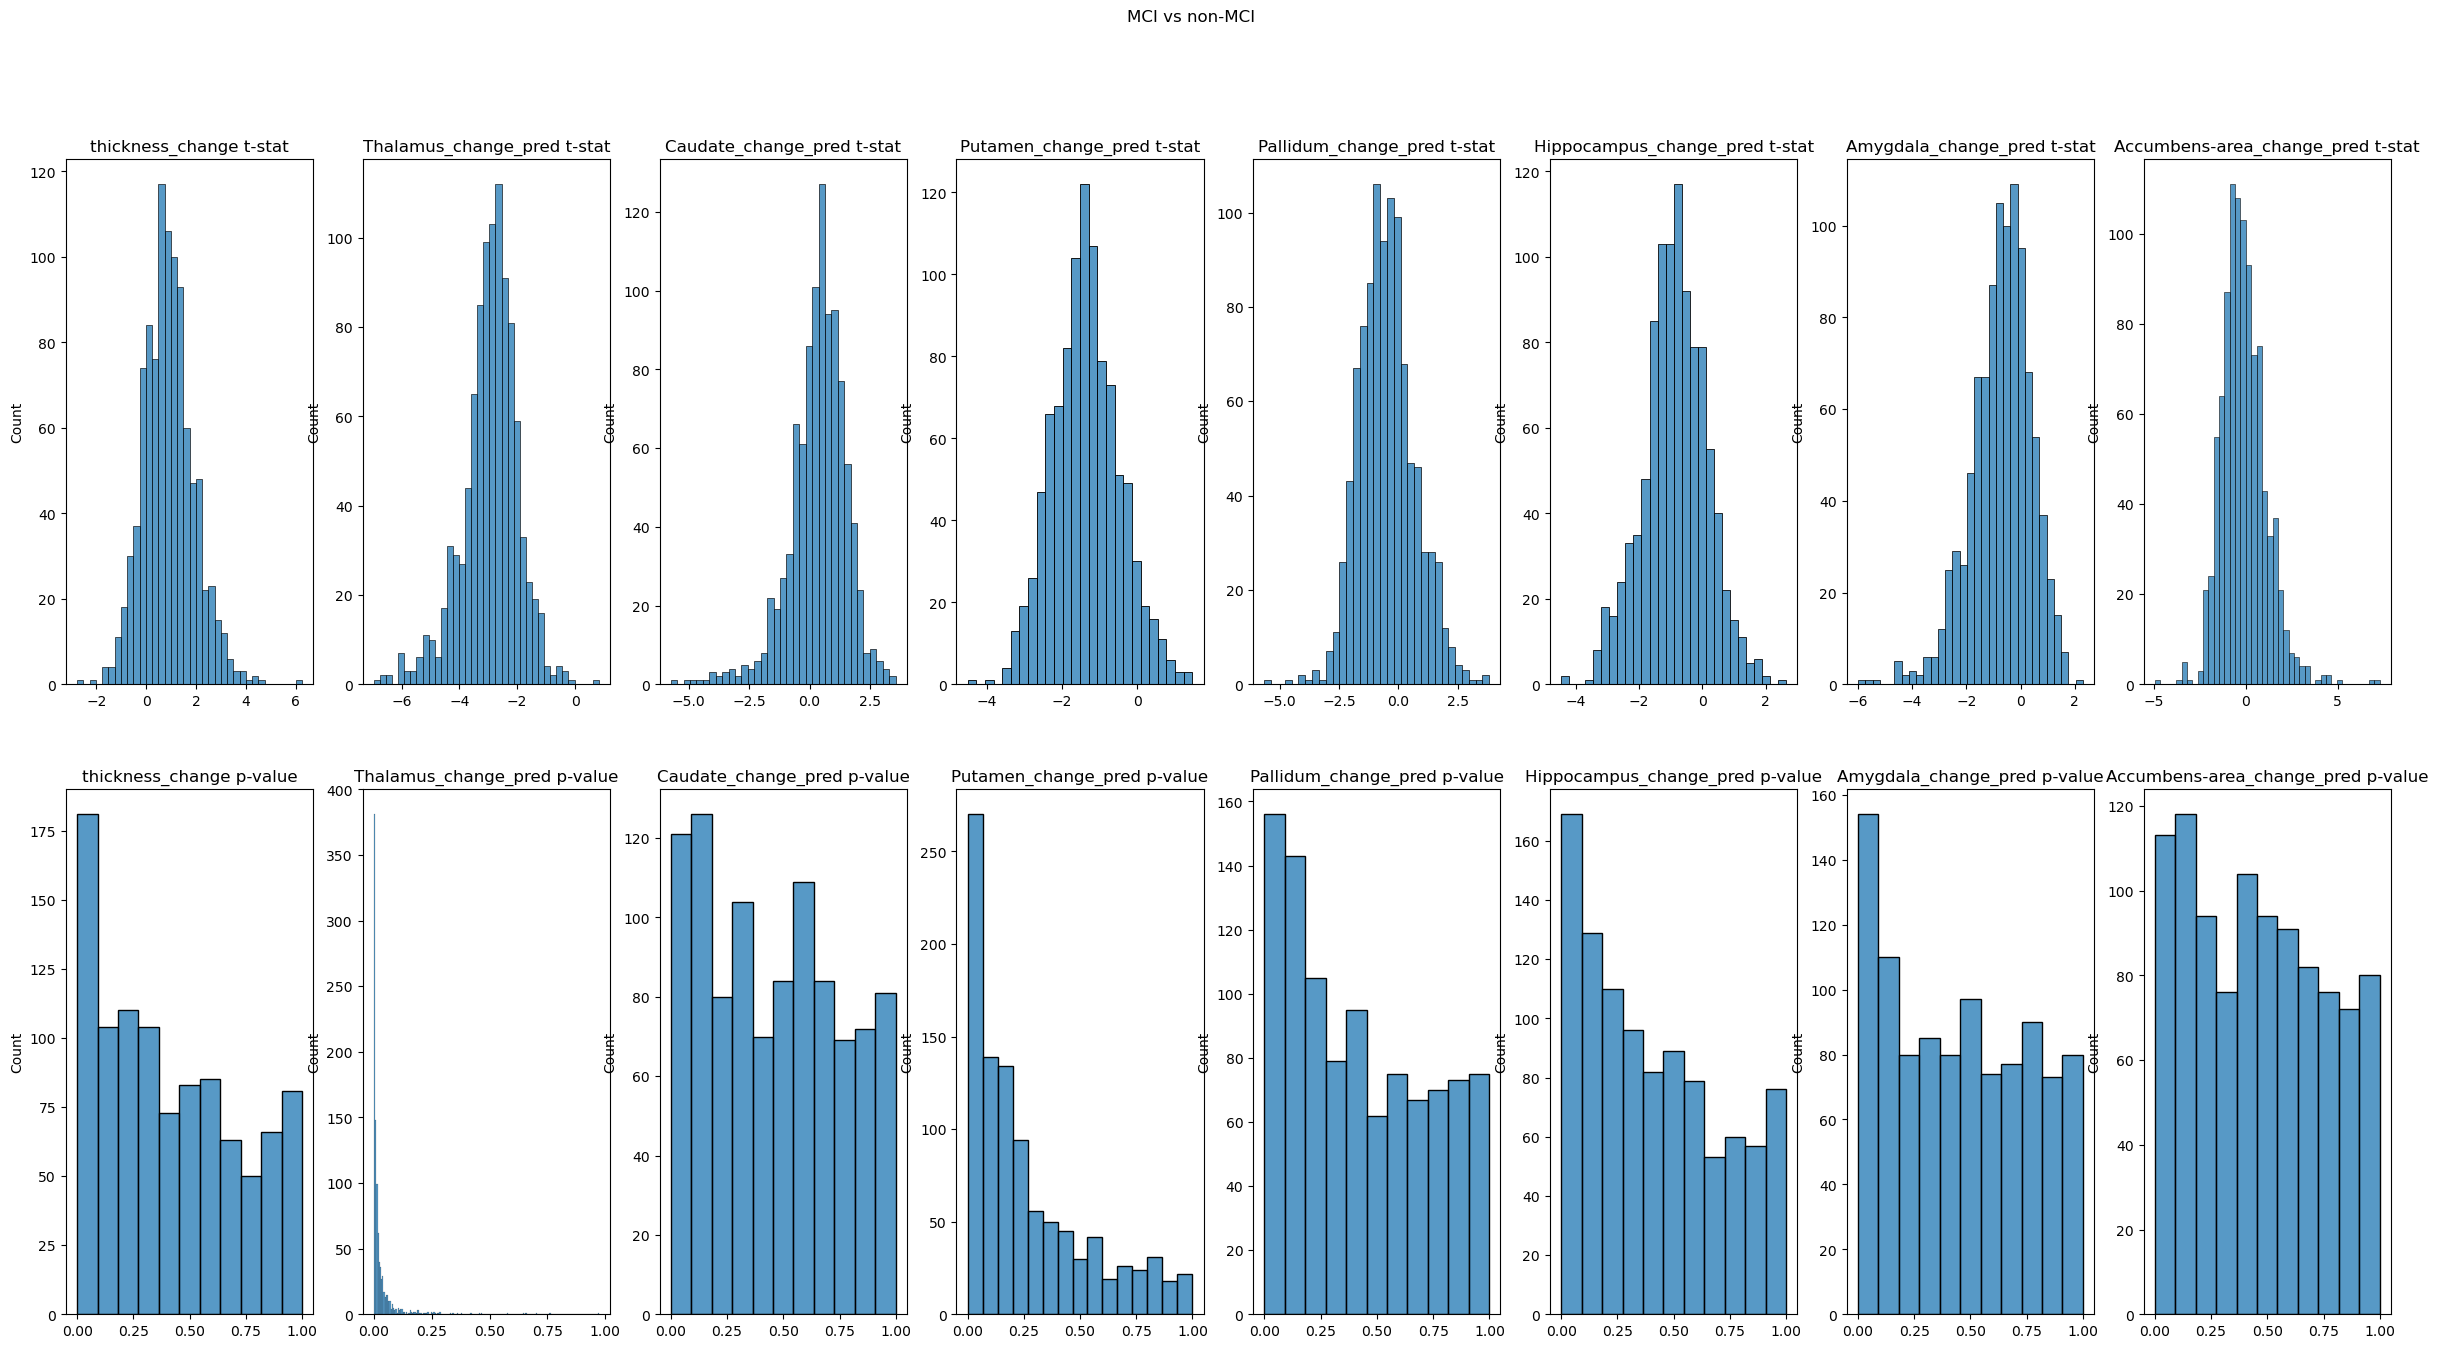

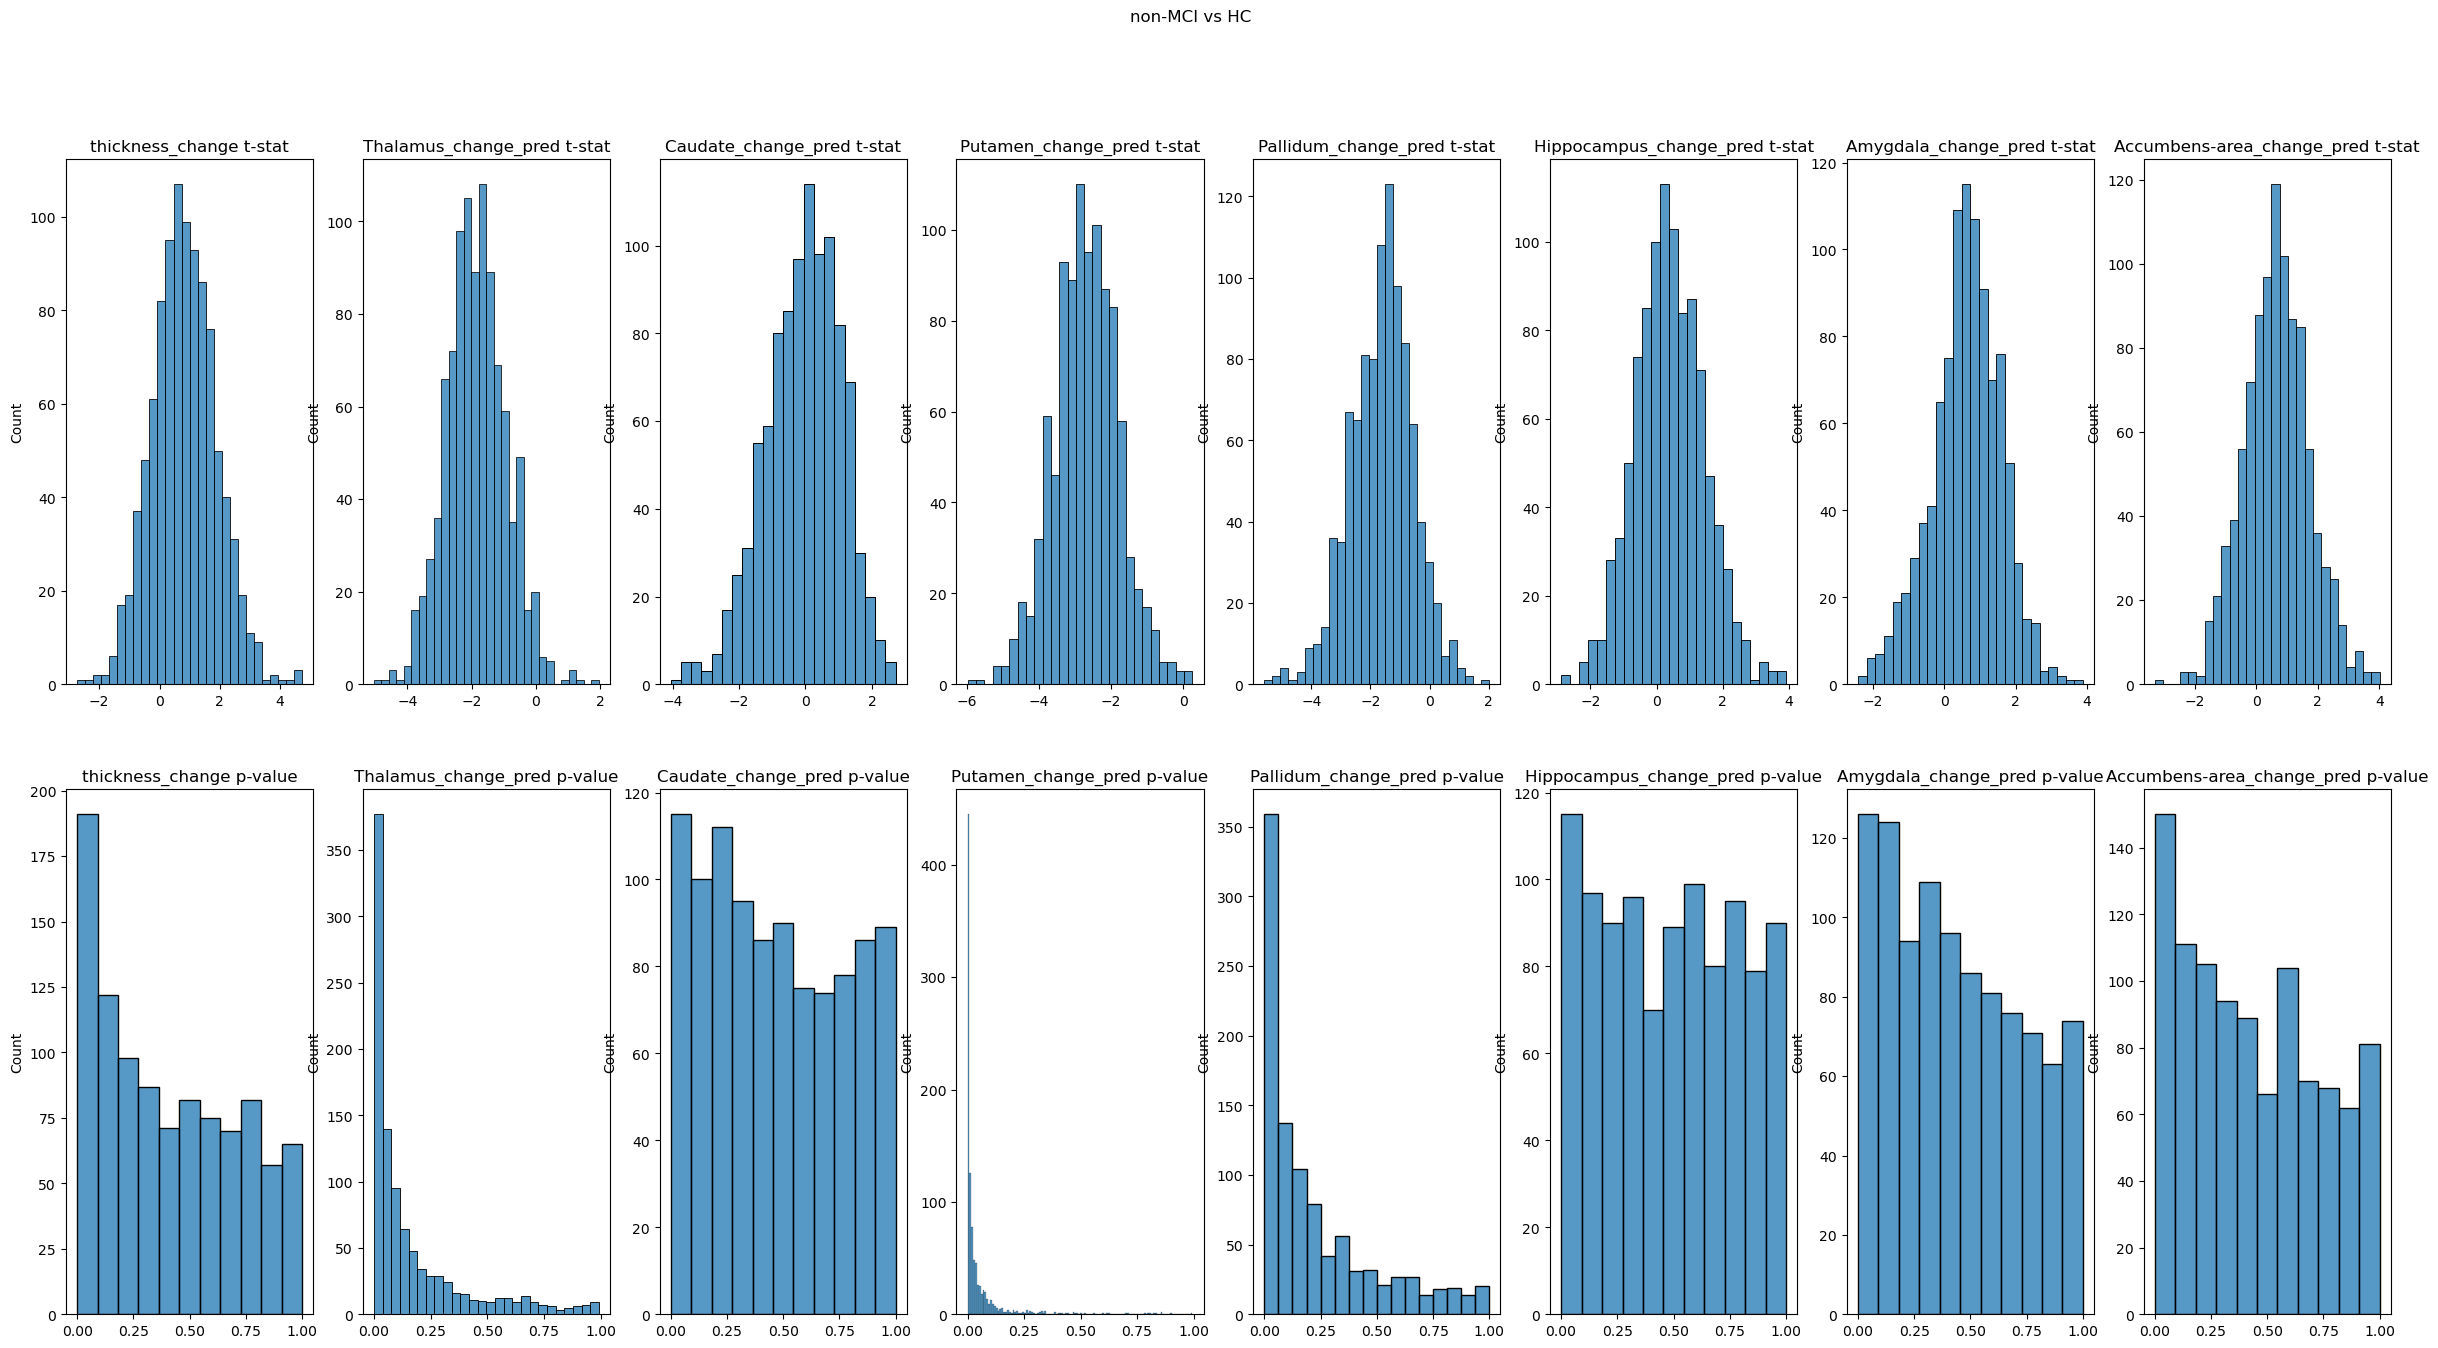

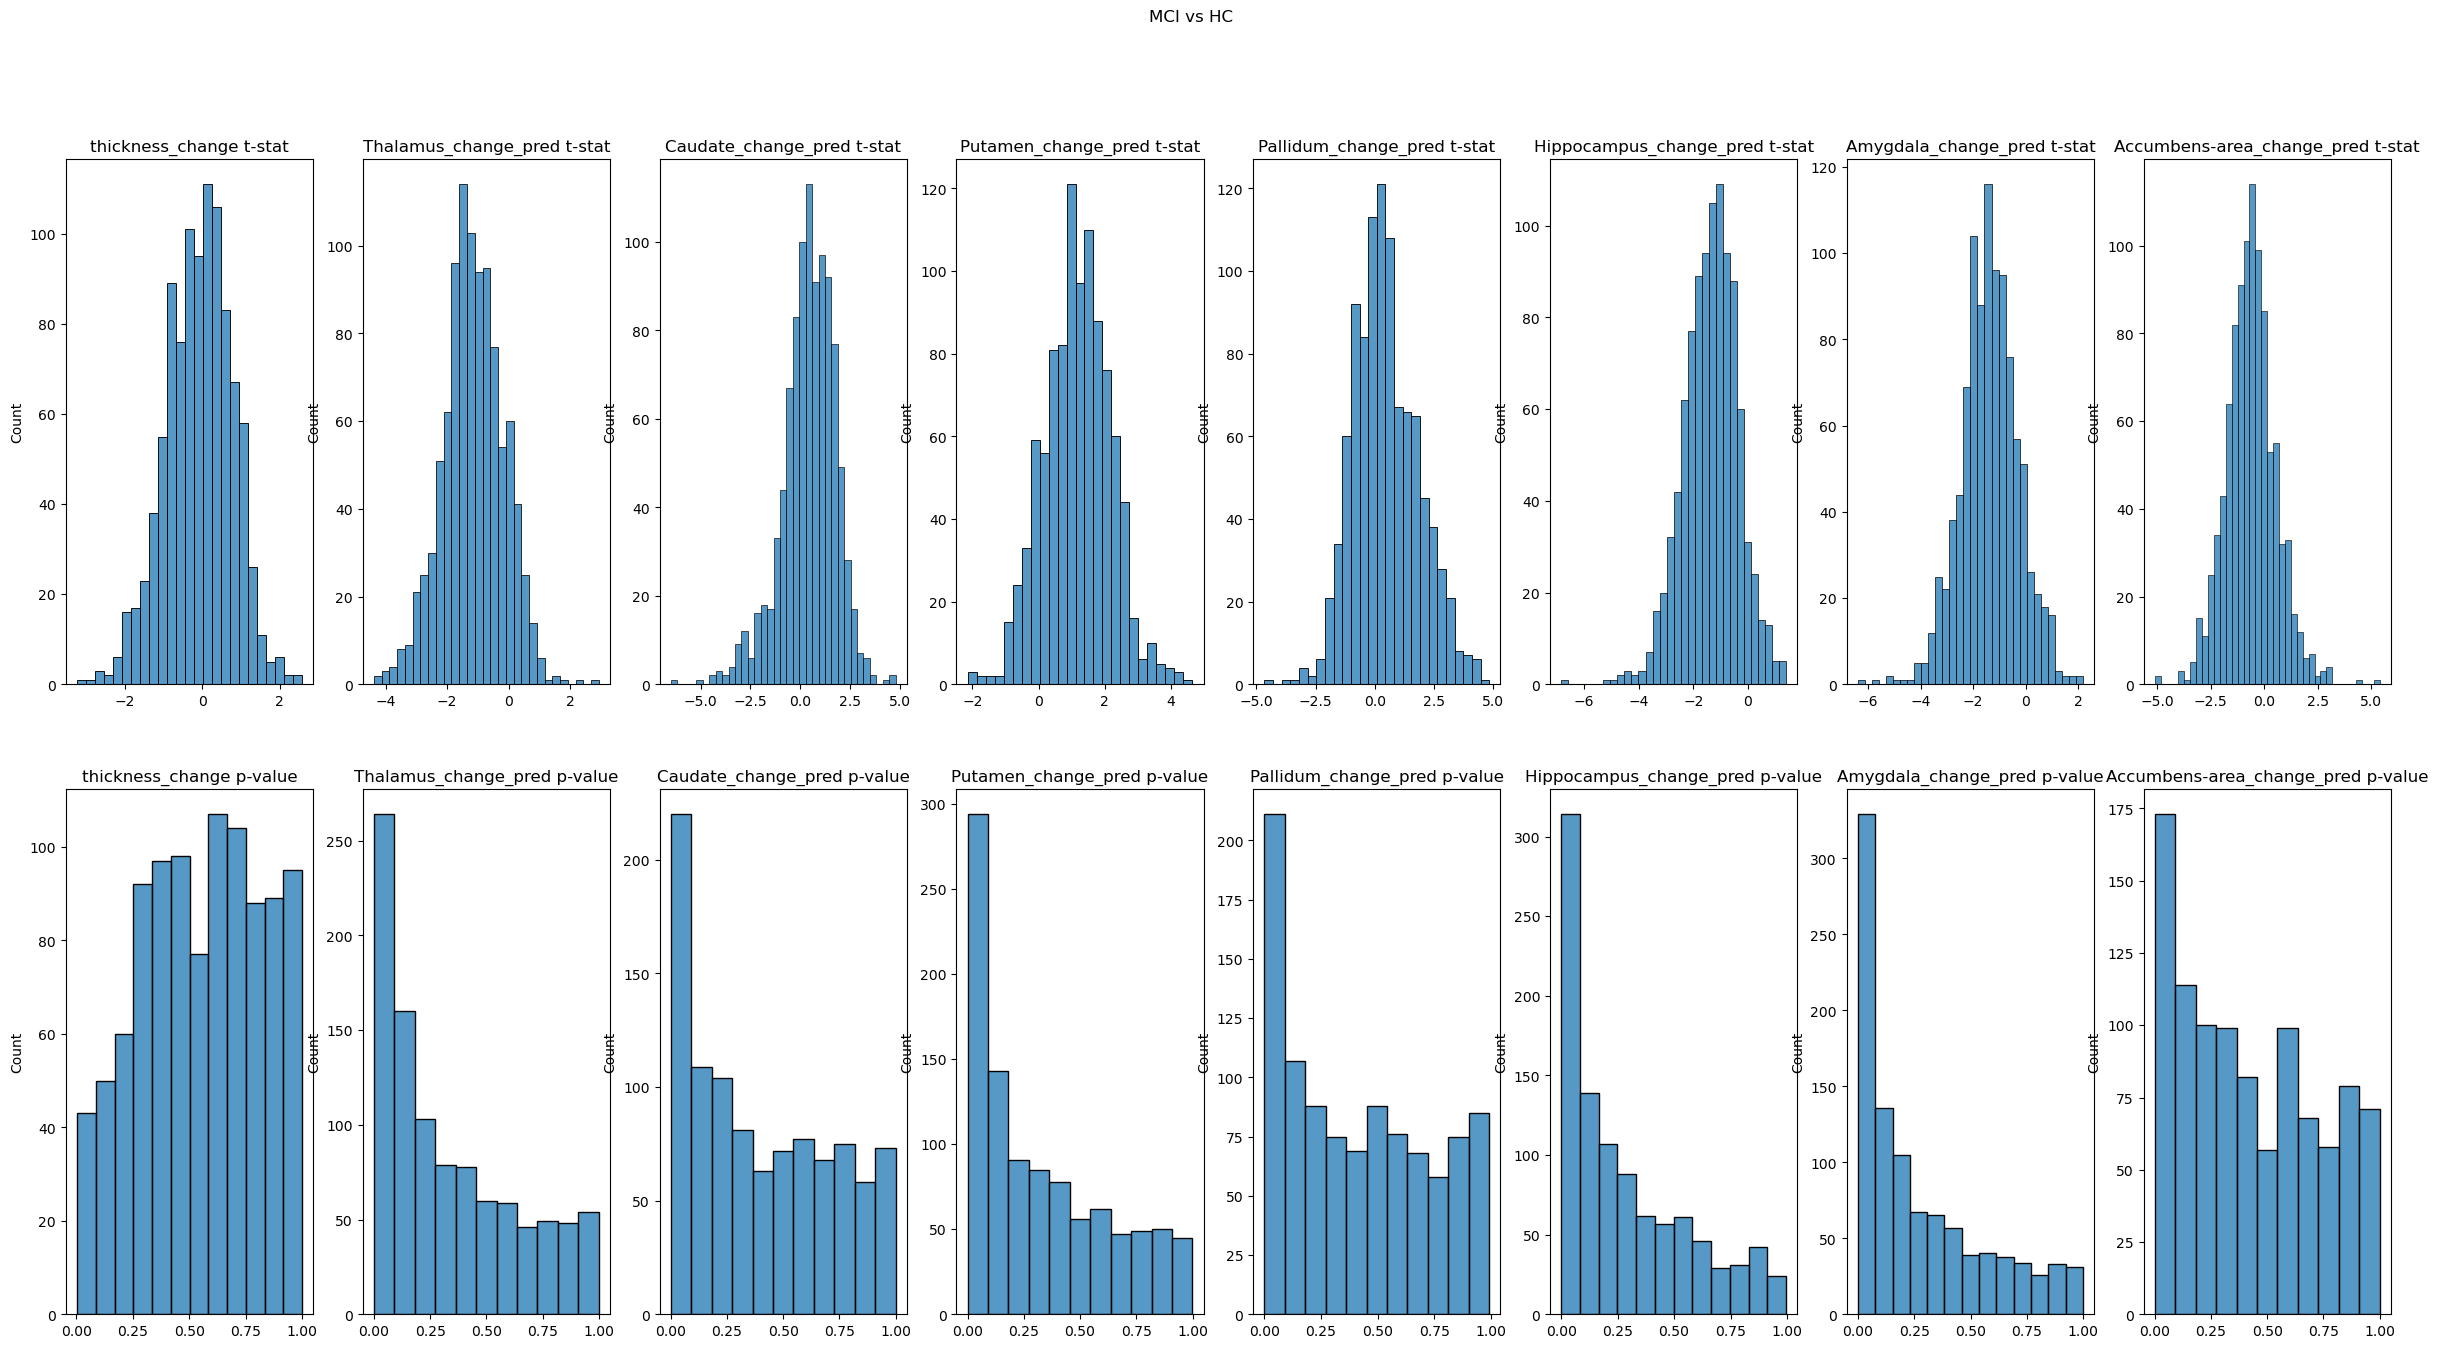

In [68]:
titles = ["MCI vs non-MCI", "non-MCI vs HC", "MCI vs HC"]
stats = [MCIvsnonMCI_stats, nonMCIvsHC_stats, MCIvsHC_stats]

for i in range(3):
    f, ax = plt.subplots(nrows=2, ncols=n_regions, figsize=(30, 15))
    f.suptitle(titles[i])
    for j in range(n_regions):
        ax[0,j].set_title(target_columns[j] + " t-stat")
        ax[0,j] = sns.histplot(stats[i][j, :, 0], ax=ax[0,j])
        ax[1,j].set_title(target_columns[j] + " p-value")
        ax[1,j] = sns.histplot(stats[i][j, :, 1], ax=ax[1,j])

In [72]:
for j in range(n_regions):    
    for i in range(3):
        print(titles[i], target_columns[j], "t-stat:", np.mean(stats[i][j, :, 0]), "p-value:", np.mean(stats[i][j, :, 1]))

MCI vs non-MCI thickness_change t-stat: 0.8905600665575881 p-value: 0.4181006299282578
non-MCI vs HC thickness_change t-stat: 0.8226799944610802 p-value: 0.4106368276863239
MCI vs HC thickness_change t-stat: -0.08132650933229384 p-value: 0.5532177768786577
MCI vs non-MCI Thalamus_change_pred t-stat: -2.9430245971016307 p-value: 0.03326804944566199
non-MCI vs HC Thalamus_change_pred t-stat: -1.8511947832756268 p-value: 0.16730892877597134
MCI vs HC Thalamus_change_pred t-stat: -1.1509860176053222 p-value: 0.3399951035582684
MCI vs non-MCI Caudate_change_pred t-stat: 0.35301743862241436 p-value: 0.45696499875423635
non-MCI vs HC Caudate_change_pred t-stat: -0.06543340654351153 p-value: 0.4688078408032014
MCI vs HC Caudate_change_pred t-stat: 0.42145640841380533 p-value: 0.40398391724742144
MCI vs non-MCI Putamen_change_pred t-stat: -1.3686700745882594 p-value: 0.2704405493263865
non-MCI vs HC Putamen_change_pred t-stat: -2.691659929433127 p-value: 0.050897808412183464
MCI vs HC Putamen_c